# Siamese network for one-shot classification
- [article](https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7)
- [github](https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch/blob/master/Siamese-networks-medium.ipynb)
- dataset: sklearn oliver face

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split

from torch.utils import data
import torch
from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F

import random

## data and preprocessing

In [19]:
## raw faces
faces = fetch_olivetti_faces()
faces.images[0].shape

(64, 64)

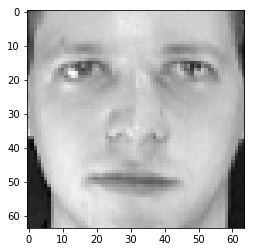

In [3]:
plt.imshow(faces.images[0], plt.cm.gray)

In [4]:
(train_images, test_images, 
 train_labels, test_labels) = train_test_split(faces.images, faces.target, test_size=0.2)

print(train_images.shape, test_images.shape)
print(train_labels.shape, test_labels.shape)

(320, 64, 64) (80, 64, 64)
(320,) (80,)


In [84]:
class FaceDataset(data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    def __len__(self):
        return self.images.shape[0] * 2 # quite arbitrary
    def __getitem__(self, i):
        N = self.images.shape[0]
        lhs = random.randint(0, N-1)
        is_same_class = np.float32(random.randint(False, True))
        if is_same_class:
            rhs = np.random.choice(np.where(self.labels == self.labels[lhs])[0])
        else:
            rhs = np.random.choice(np.where(self.labels != self.labels[lhs])[0])
        return (self.images[lhs][None, ...], self.images[rhs][None, ...], is_same_class)
    
train_faces = FaceDataset(train_images, train_labels)
test_faces = FaceDataset(test_images, test_labels)

1.0


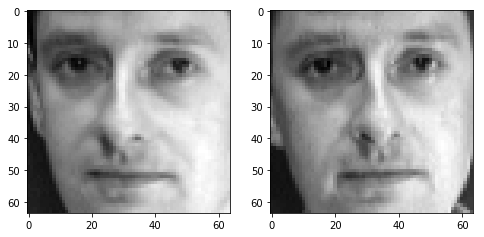

In [85]:
i = random.randint(0, 1000)
face1, face2, lab = train_faces[i]
fig, axes = plt.subplots(1, 2, figsize=(8, 5))
axes[0].imshow(face1.squeeze(), plt.cm.gray)
axes[1].imshow(face2.squeeze(), plt.cm.gray)
# fig.suptitle(lab)
print(lab)

## model

In [176]:
IMG_SIZE = 64


class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, 2, stride=1), # 64 -> (64-2)//1 + 1 = 63
            nn.BatchNorm2d(16),
            nn.ELU(inplace=True),
            nn.Dropout2d(0.3),
            
            nn.AvgPool2d(2, padding=1), ## (63+1*2) // 2 = 32
            
            nn.Conv2d(16, 32, 4, stride=2), # 32 -> (32-4)//2 + 1= 15
            nn.BatchNorm2d(32),
            nn.ELU(inplace=True),
            nn.Dropout2d(0.3),
            
            nn.AvgPool2d(2, padding=1), ## 15 -> (15+2*1) // 2 = 8
            
            nn.Conv2d(32, 128, 2, stride=2), ## 8 -> (8-4) // 2 + 1 = 3
            nn.BatchNorm2d(128),
            nn.ELU(inplace=True),
            nn.Dropout2d(0.2),
            
#             nn.AvgPool2d(4) # 4 -> 4 / 4 = 1 # stupid performance bottleneck
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128*4*4, 128),
            nn.ELU(inplace=True),
            
            nn.Linear(128, 64),
            nn.ELU(inplace=True),
            
            nn.Linear(64, 8)
        )
    def forward_one(self, img):
        batch_size = img.size(0)
        out = self.cnn(img).view([batch_size, -1])
        out = self.fc(out)
        return out
    def forward(self, img1, img2):
        feat1 = self.forward_one(img1)
        feat2 = self.forward_one(img2)
        return feat1, feat2

In [177]:
# a = nn.Sequential(
#     nn.Conv2d(1, 16, 2, stride=1),
#     nn.AvgPool2d(2, padding=1),
#     nn.Conv2d(16, 32, 4, stride=2),
#     nn.AvgPool2d(2, padding=1),
#     nn.Conv2d(32, 128, 2, stride=2),
#     nn.AvgPool2d(4)
# )
a = SiameseNetwork()

x = Variable(torch.randn([10, 1, 64, 64]))
y, yy = a(x, x)
y.size(), yy.size()

(torch.Size([10, 8]), torch.Size([10, 8]))

## Contrastive Loss

In [178]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    def forward(self, feat1, feat2, label):
        d = F.pairwise_distance(feat1, feat2)
        same_class_loss = torch.pow(d, 2)
        diff_class_loss = torch.pow(torch.clamp(self.margin-d, min=0), 2)
        loss = label * same_class_loss + (1-label) * diff_class_loss
        return loss

In [179]:
objective = ContrastiveLoss()

In [180]:
objective(y, yy, 1)

Variable containing:
 0.0731
 0.0740
 0.1656
 0.1825
 0.0784
 0.0564
 0.0460
 0.1658
 0.0785
 0.0817
[torch.FloatTensor of size 10x1]

## Training

In [181]:
n_epoch = 100
batch_size = 100

log = []

train_pairs = data.DataLoader(train_faces, batch_size=100, num_workers=2, shuffle=True)
test_pairs = data.DataLoader(test_faces, batch_size=100, num_workers=2, shuffle=False)

model = SiameseNetwork()
model.train()
optimizer = optim.Adam(model.parameters(), lr=5e-4)
objective = ContrastiveLoss()

for epoch in range(n_epoch):
    for b, (images1, images2, labels) in enumerate(train_pairs):
        x1 = Variable(images1)
        x2 = Variable(images2)
        y = Variable(labels)
        
        model.zero_grad()
        f1, f2 = model(x1, x2)
        loss = objective(f1, f2, y).mean()
        loss.backward()
        optimizer.step()
        log.append(loss.data[0])
        
        if b % 200 == 0:
            print(epoch, b, loss.data[0])

0 0 1.3022223711013794
1 0 0.9505182504653931
2 0 0.667103111743927
3 0 0.5652947425842285
4 0 0.5803928971290588
5 0 0.5850322246551514
6 0 0.5637295246124268
7 0 0.4624861180782318
8 0 0.45672178268432617
9 0 0.43815383315086365
10 0 0.36356502771377563
11 0 0.3384430706501007
12 0 0.3580307066440582
13 0 0.3394829034805298
14 0 0.2981019914150238
15 0 0.4068448841571808
16 0 0.27818289399147034
17 0 0.3535287082195282
18 0 0.3209855854511261
19 0 0.3525458574295044
20 0 0.2843112349510193
21 0 0.2634987533092499
22 0 0.36864331364631653
23 0 0.26408395171165466
24 0 0.23122532665729523
25 0 0.25981393456459045
26 0 0.23489835858345032
27 0 0.21825052797794342
28 0 0.2602834403514862
29 0 0.2436339557170868
30 0 0.20442819595336914
31 0 0.18669310212135315
32 0 0.31362465023994446
33 0 0.2566467821598053
34 0 0.17443034052848816
35 0 0.19238369166851044
36 0 0.14931514859199524
37 0 0.1758124679327011
38 0 0.222957044839859
39 0 0.18582631647586823
40 0 0.21477501094341278
41 0 0.170

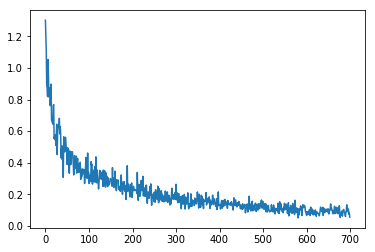

In [182]:
plt.plot(log)

In [198]:
## evaluation
model.eval()

ys = []
dists = []

for b, (images1, images2, labels) in enumerate(test_pairs):
    x1 = Variable(images1)
    x2 = Variable(images2)
    y = Variable(labels)

    f1, f2 = model(x1, x2)
    dist = F.pairwise_distance(f1, f2).squeeze()
    
    ys.append(y.data.numpy())
    dists.append(dist.data.numpy())
    
ys = np.concatenate(ys)
dists = np.concatenate(dists)

In [199]:
np.mean(dists[ys>=0.5]), np.mean(dists[ys<0.5])

(0.21742581, 2.5501454)

label
non-similiar    Axes(0.125,0.125;0.775x0.755)
similiar        Axes(0.125,0.125;0.775x0.755)
Name: dist, dtype: object

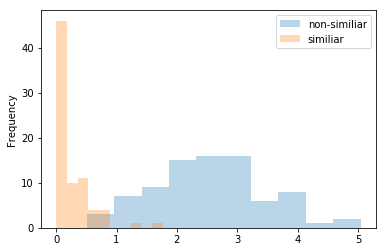

In [201]:
import pandas as pd
df = pd.DataFrame({"dist": dists, "label": np.where(ys > 0.5, "similiar", "non-similiar")})
df.groupby("label").dist.plot(kind="hist", alpha=0.3, legend=True)